In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import torch.nn.functional as F
import time
from torchvision.datasets import STL10

In [3]:
import torch.nn.init as init
import math

In [4]:
# Data augmentation transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load the STL-10 dataset
trainset = STL10(root='./data', split='train', download=True, transform=transform_train)
testset = STL10(root='./data', split='test', download=True, transform=transform_test)

# Split the training set into train and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 2640397119/2640397119 [02:55<00:00, 15025826.75it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}

In [7]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 10),
        )
        
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)




In [8]:
# Initialize lists for storing training and testing data
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Function for training
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total, total, correct

# Function for testing
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total, total, correct

In [9]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/vgg11_stl10v_1'
writer = SummaryWriter(log_dir)

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VGG16 model
num_classes = 10
vgg11_model = VGG(make_layers(cfg['vgg11'])).to(device)

print(vgg11_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [11]:
# Train the model
num_epochs = 30
vgg11_train_losses = []
vgg11_train_accs = []
vgg11_val_losses = []
vgg11_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(vgg11_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(vgg11_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    vgg11_train_losses.append(train_loss)
    vgg11_train_accs.append(train_acc)
    vgg11_val_losses.append(val_loss)
    vgg11_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

Testing Accuracy: 13.9%
Epoch [1/30], Train Loss: 2.2928, Train Acc: 11.05, Val Loss: 2.2468, Val Acc: 13.90
Testing Accuracy: 24.6%
Epoch [2/30], Train Loss: 2.0954, Train Acc: 21.38, Val Loss: 1.9421, Val Acc: 24.60
Testing Accuracy: 23.5%
Epoch [3/30], Train Loss: 1.9759, Train Acc: 26.23, Val Loss: 1.9186, Val Acc: 23.50
Testing Accuracy: 32.0%
Epoch [4/30], Train Loss: 1.8063, Train Acc: 28.95, Val Loss: 1.6994, Val Acc: 32.00
Testing Accuracy: 32.9%
Epoch [5/30], Train Loss: 1.6677, Train Acc: 33.58, Val Loss: 1.6714, Val Acc: 32.90
Testing Accuracy: 41.3%
Epoch [6/30], Train Loss: 1.6060, Train Acc: 37.70, Val Loss: 1.5423, Val Acc: 41.30
Testing Accuracy: 43.3%
Epoch [7/30], Train Loss: 1.5313, Train Acc: 40.33, Val Loss: 1.5151, Val Acc: 43.30
Testing Accuracy: 44.6%
Epoch [8/30], Train Loss: 1.4609, Train Acc: 44.40, Val Loss: 1.4994, Val Acc: 44.60
Testing Accuracy: 49.1%
Epoch [9/30], Train Loss: 1.3907, Train Acc: 47.33, Val Loss: 1.3443, Val Acc: 49.10
Testing Accuracy: 5

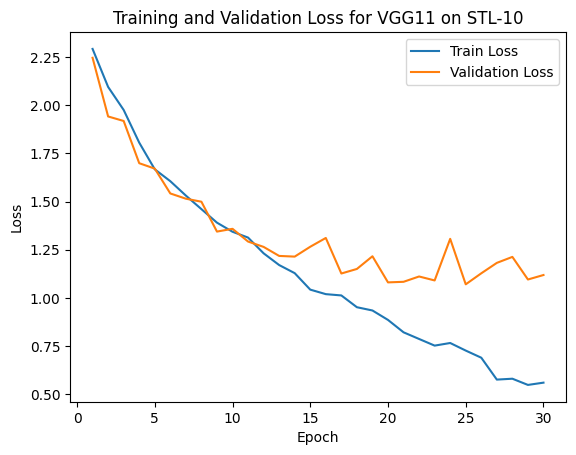

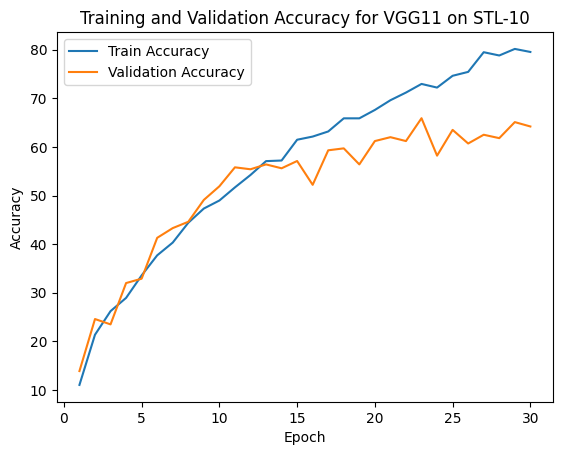

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg11_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), vgg11_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG11 on STL-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg11_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg11_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG11 on STL-10')
plt.show()

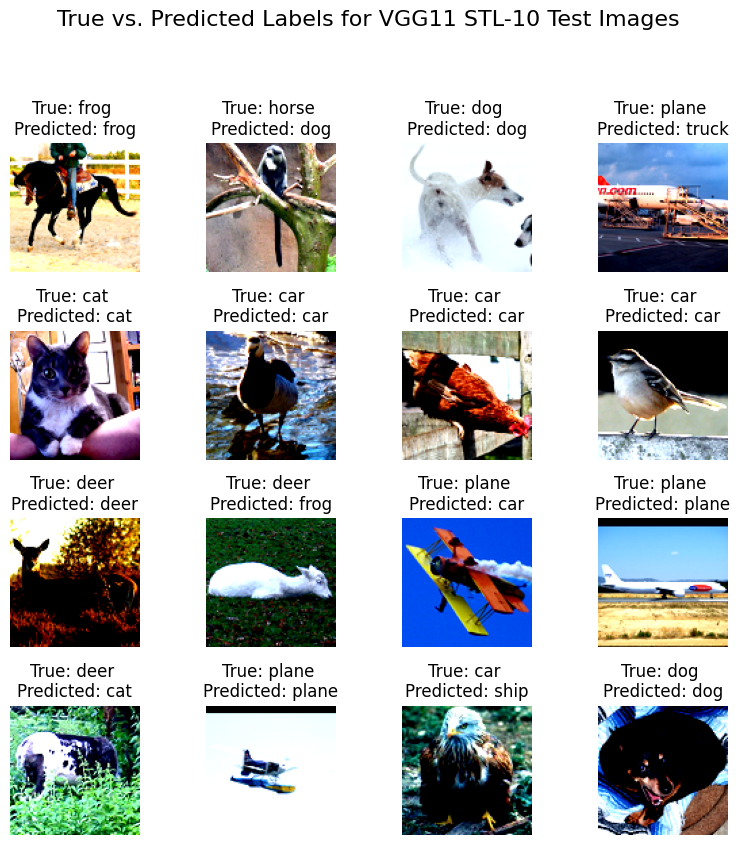

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(vgg11_model, test_loader)
plt.suptitle('True vs. Predicted Labels for VGG11 STL-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [14]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/vgg13_stl10v_1'
writer = SummaryWriter(log_dir)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VGG16 model
num_classes = 10
vgg13_model = VGG(make_layers(cfg['vgg13'])).to(device)

print(vgg13_model)

# Train the model
num_epochs = 30
vgg13_train_losses = []
vgg13_train_accs = []
vgg13_val_losses = []
vgg13_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg13_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(vgg13_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(vgg13_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    vgg13_train_losses.append(train_loss)
    vgg13_train_accs.append(train_acc)
    vgg13_val_losses.append(val_loss)
    vgg13_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

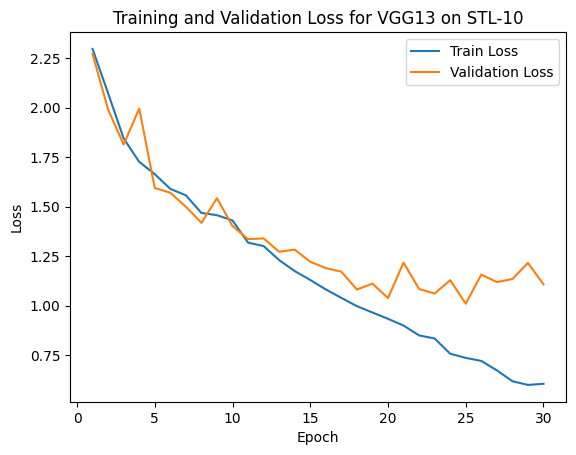

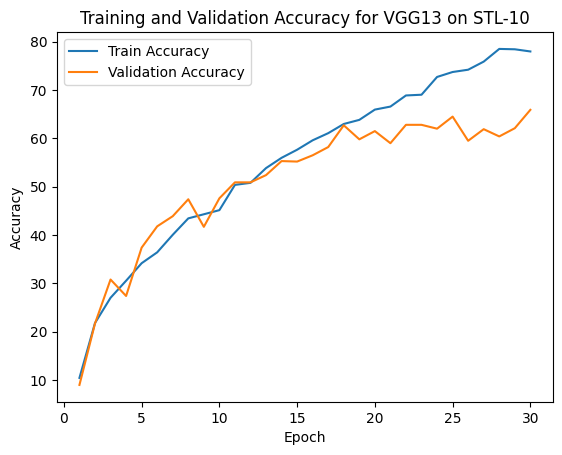

In [15]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg13_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), vgg13_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG13 on STL-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg13_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg13_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG13 on STL-10')
plt.show()

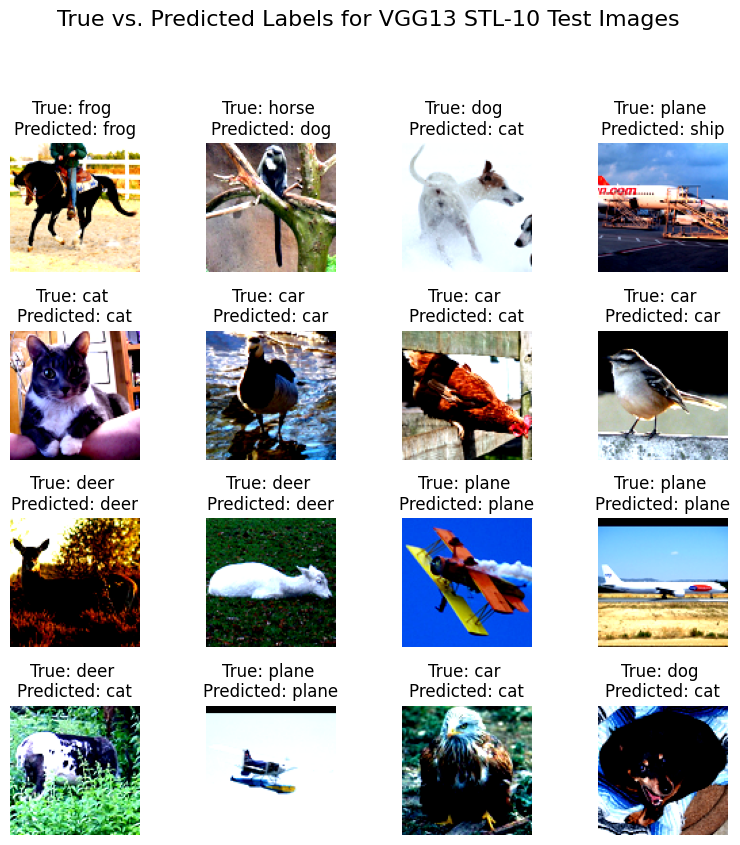

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(vgg13_model, test_loader)
plt.suptitle('True vs. Predicted Labels for VGG13 STL-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [17]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/vgg16_stl10v_1'
writer = SummaryWriter(log_dir)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VGG16 model
num_classes = 10
vgg16_model = VGG(make_layers(cfg['vgg16'])).to(device)

print(vgg16_model)

# Train the model
num_epochs = 30
vgg16_train_losses = []
vgg16_train_accs = []
vgg16_val_losses = []
vgg16_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(vgg16_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(vgg16_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    vgg16_train_losses.append(train_loss)
    vgg16_train_accs.append(train_acc)
    vgg16_val_losses.append(val_loss)
    vgg16_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

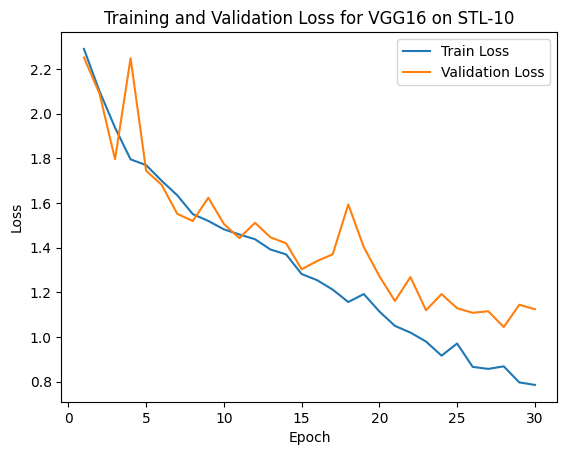

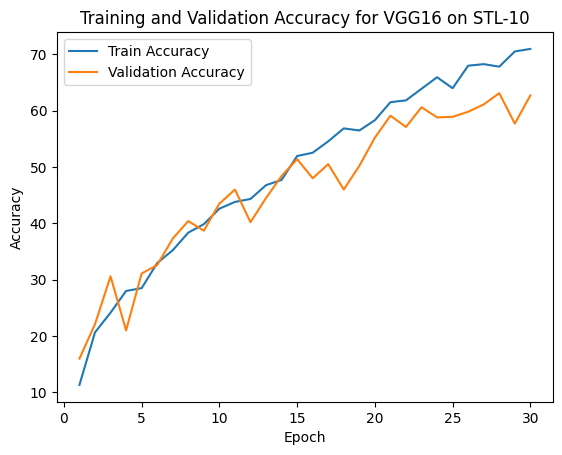

In [18]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg16_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), vgg16_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG16 on STL-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg16_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg16_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG16 on STL-10')
plt.show()

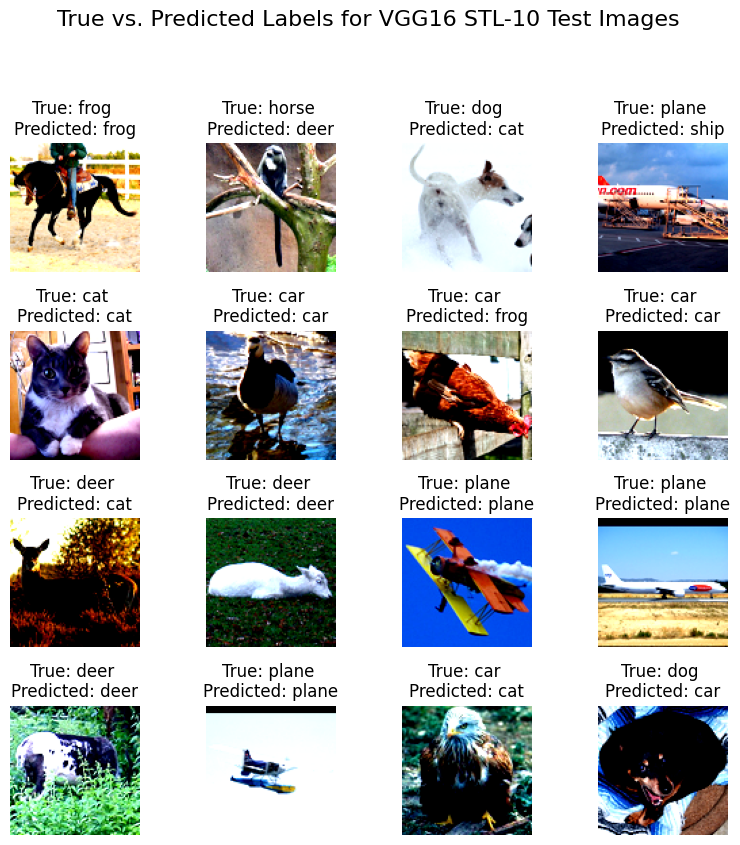

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(vgg16_model, test_loader)
plt.suptitle('True vs. Predicted Labels for VGG16 STL-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [20]:
# Import the required libraries for TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter for TensorBoard
log_dir = './runs/vgg19_stl10v_1'
writer = SummaryWriter(log_dir)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VGG16 model
num_classes = 10
vgg19_model = VGG(make_layers(cfg['vgg19'])).to(device)

print(vgg16_model)

# Train the model
num_epochs = 30
vgg19_train_losses = []
vgg19_train_accs = []
vgg19_val_losses = []
vgg19_val_accs = []

# Define the loss function and the optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_acc, train_total, train_correct = train(vgg19_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, test_total, test_correct  = test(vgg19_model, val_loader, criterion, device)

    # Add scalar values to the writer
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    vgg19_train_losses.append(train_loss)
    vgg19_train_accs.append(train_acc)
    vgg19_val_losses.append(val_loss)
    vgg19_val_accs.append(val_acc)

    test_accuracy = 100 * test_correct / test_total
    print(f"Testing Accuracy: {test_accuracy}%")

    # Update the learning rate scheduler
    #scheduler.step(test_accuracy)

    #scheduler.step()
    
  
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

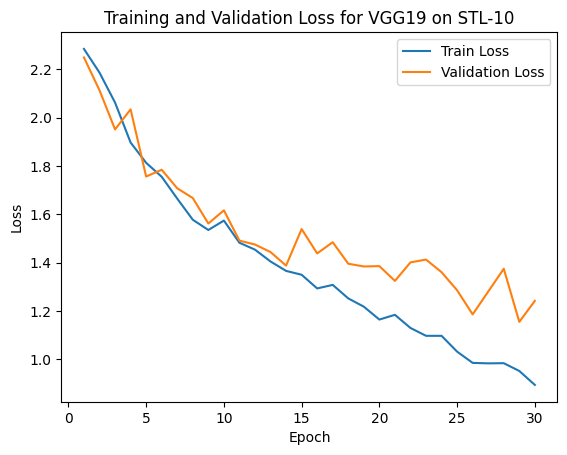

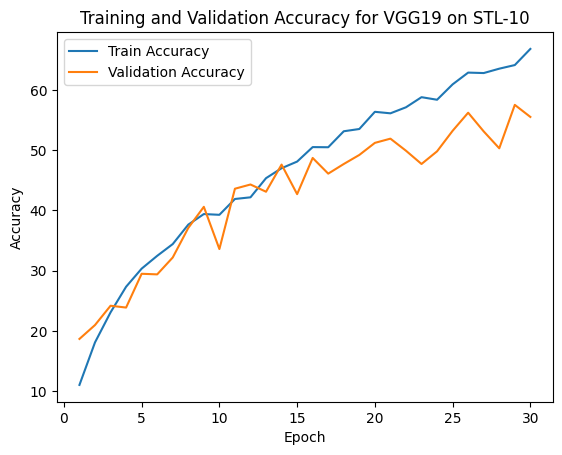

In [21]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg19_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), vgg19_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG19 on STL-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg19_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg19_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG19 on STL-10')
plt.show()

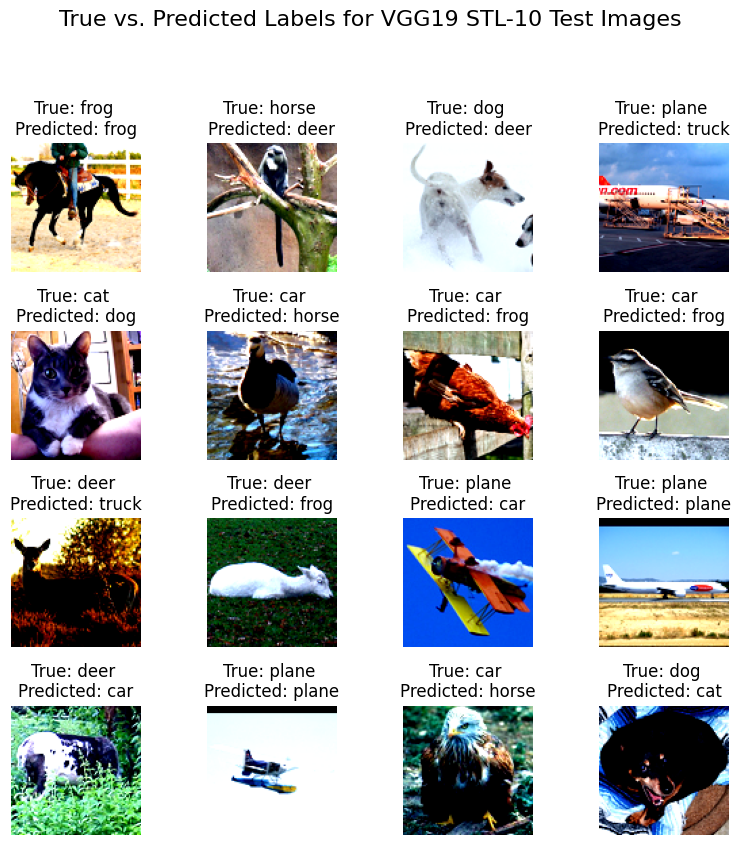

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('True: {} \nPredicted: {}'.format(classes[labels[j].item()], classes[preds[j].item()]))
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * 0.5 + 0.5, 0, 1)  # unnormalize
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_predictions(vgg19_model, test_loader)
plt.suptitle('True vs. Predicted Labels for VGG19 STL-10 Test Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

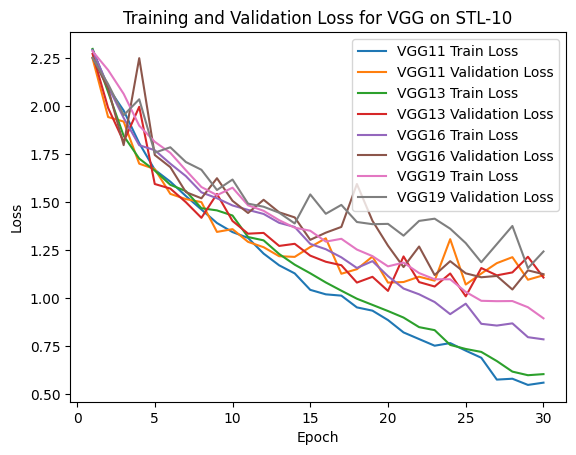

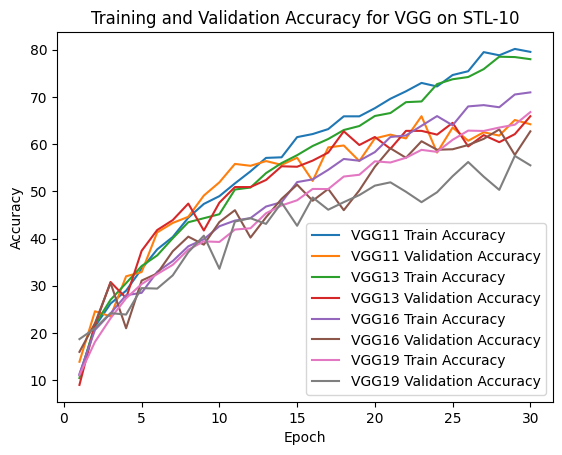

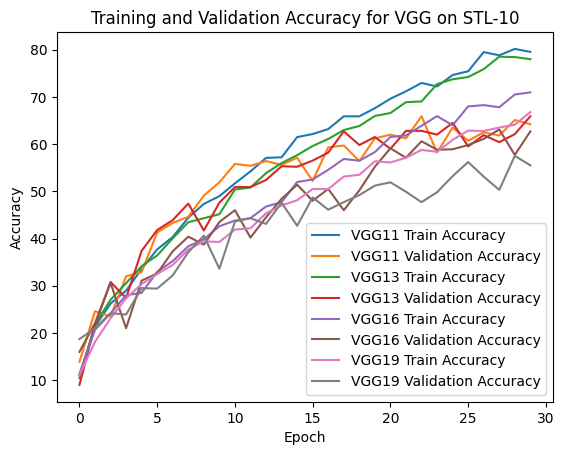

In [23]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg11_train_losses, label='VGG11 Train Loss')
plt.plot(range(1, num_epochs + 1), vgg11_val_losses, label='VGG11 Validation Loss')
plt.plot(range(1, num_epochs + 1), vgg13_train_losses, label='VGG13 Train Loss')
plt.plot(range(1, num_epochs + 1), vgg13_val_losses, label='VGG13 Validation Loss')
plt.plot(range(1, num_epochs + 1), vgg16_train_losses, label='VGG16 Train Loss')
plt.plot(range(1, num_epochs + 1), vgg16_val_losses, label='VGG16 Validation Loss')
plt.plot(range(1, num_epochs + 1), vgg19_train_losses, label='VGG19 Train Loss')
plt.plot(range(1, num_epochs + 1), vgg19_val_losses, label='VGG19 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for VGG on STL-10')
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), vgg11_train_accs, label='VGG11 Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg11_val_accs, label='VGG11 Validation Accuracy')
plt.plot(range(1, num_epochs + 1), vgg13_train_accs, label='VGG13 Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg13_val_accs, label='VGG13 Validation Accuracy')
plt.plot(range(1, num_epochs + 1), vgg16_train_accs, label='VGG16 Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg16_val_accs, label='VGG16 Validation Accuracy')
plt.plot(range(1, num_epochs + 1), vgg19_train_accs, label='VGG19 Train Accuracy')
plt.plot(range(1, num_epochs + 1), vgg19_val_accs, label='VGG19 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG on STL-10')
plt.show()
# Plot the training and validation accuracy
plt.figure()
plt.plot(vgg11_train_accs, label='VGG11 Train Accuracy')
plt.plot(vgg11_val_accs, label='VGG11 Validation Accuracy')
plt.plot(vgg13_train_accs, label='VGG13 Train Accuracy')
plt.plot(vgg13_val_accs, label='VGG13 Validation Accuracy')
plt.plot(vgg16_train_accs, label='VGG16 Train Accuracy')
plt.plot(vgg16_val_accs, label='VGG16 Validation Accuracy')
plt.plot(vgg19_train_accs, label='VGG19 Train Accuracy')
plt.plot(vgg19_val_accs, label='VGG19 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for VGG on STL-10')
plt.show()

In [24]:
%load_ext tensorboard

%tensorboard --logdir runs

<IPython.core.display.Javascript object>